In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, max_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import time
from sklearn.compose import ColumnTransformer

In [34]:
merged_data = pd.read_csv('https://github.com/edeliciouso/Predicting-Yields-for-Potatoes/blob/main/MergedDataFinal4.csv?raw=true')
merged_data = merged_data.drop(['Item', 'Year'], axis = 1)
merged_data

,Country,Yield (100 hg/ha),Pesticides (Tons),Rainfall (mm),Fertilizer (kg/ha)
0,Albania,55693,410.55,1485.0,79.08
1,Albania,66790,590.50,1485.0,76.47
2,Albania,59869,582.68,1485.0,87.08
3,Albania,67290,361.62,1485.0,82.79
4,Albania,69533,450.60,1485.0,78.15
...,...,...,...,...,...
1194,Zimbabwe,5803,2185.07,657.0,19.17
1195,Zimbabwe,4405,2185.07,657.0,31.78
1196,Zimbabwe,13933,2185.07,657.0,35.71
1197,Zimbabwe,13506,2185.07,657.0,32.39


In [35]:
features = ['Pesticides (Tons)', 'Rainfall (mm)', 'Fertilizer (kg/ha)', 'Country']
target = 'Yield (100 hg/ha)'

X = merged_data[features]
y = merged_data[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [36]:
# Create transformers for numeric and categorical features
numeric_features = ['Pesticides (Tons)', 'Rainfall (mm)', 'Fertilizer (kg/ha)']
categorical_features = ['Country']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline with scaling, one-hot encoding, and Decision Tree
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('dt', DecisionTreeRegressor())
])

# Define the hyperparameter grid for GridSearchCV
param_grid = {
    'dt__max_depth': [3, 5, 7, 10],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 2, 4]
}

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='r2', error_score='raise')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Pesticides '
                                                                          '(Tons)',
                                                                          'Rainfall '
                                                                          '(mm)',
                                                                          'Fertilizer '
                                                                          '(kg/ha)']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['Country'])])),
                                       ('dt', DecisionTreeRegressor())]),
             param_grid={'dt__max_depth': [3, 5, 7, 10],
                         'dt__min_samples_leaf': [1, 2, 4],
                         'dt__min_samples_split': [2, 5, 10]},
             scoring='r2')

In [37]:
# Get the best estimator from the grid search
best_estimator_dt = grid_search.best_estimator_

# Training the DecisionTreeRegressor model
start_training_time_dt = time.time()
best_estimator_dt.fit(X_train, y_train)
end_training_time_dt = time.time()
training_time_dt = end_training_time_dt - start_training_time_dt

# Make predictions
start_prediction_time_dt = time.time()
y_pred = best_estimator_dt.predict(X_test)
end_prediction_time_dt = time.time()
prediction_time_dt = end_prediction_time_dt - start_prediction_time_dt

In [38]:
# Evaluate the model
r2_dt = r2_score(y_test, y_pred)  # R^2
mae_dt = mean_absolute_error(y_test, y_pred)  # mean absolute error
mse_dt = mean_squared_error(y_test, y_pred)  # mean squared error
rmse_dt = mean_squared_error(y_test, y_pred, squared=False)  # root mean squared error
max_err_dt = max_error(y_test, y_pred)  # max error
mape_dt = mean_absolute_percentage_error(y_test, y_pred)  # mean absolute percentage error

print(f"Decision Tree Regression Metrics:")
print(f"R-squared (R2): {r2_dt:.2f}")
print(f"Mean Absolute Error (MAE): {mae_dt:.2f}")
print(f"Mean Squared Error (MSE): {mse_dt:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_dt:.2f}")
print(f"Max Error: {max_err_dt:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_dt:.2f}%")
print(f"Training Time: {training_time_dt:.2f} seconds")
print(f"Prediction Time: {prediction_time_dt:.5f} seconds")

Decision Tree Regression Metrics:
R-squared (R2): 0.80
Mean Absolute Error (MAE): 10178.14
Mean Squared Error (MSE): 384340727.03
Root Mean Squared Error (RMSE): 19604.61
Max Error: 158917.00
Mean Absolute Percentage Error (MAPE): 0.22%
Training Time: 0.01 seconds
Prediction Time: 0.00334 seconds


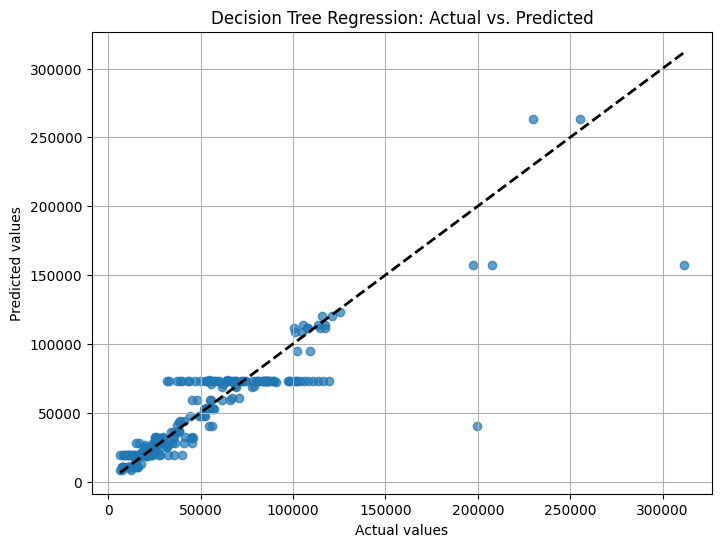

In [39]:
# Visualize predictions vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Decision Tree Regression: Actual vs. Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line for reference
plt.grid(True)
plt.show()

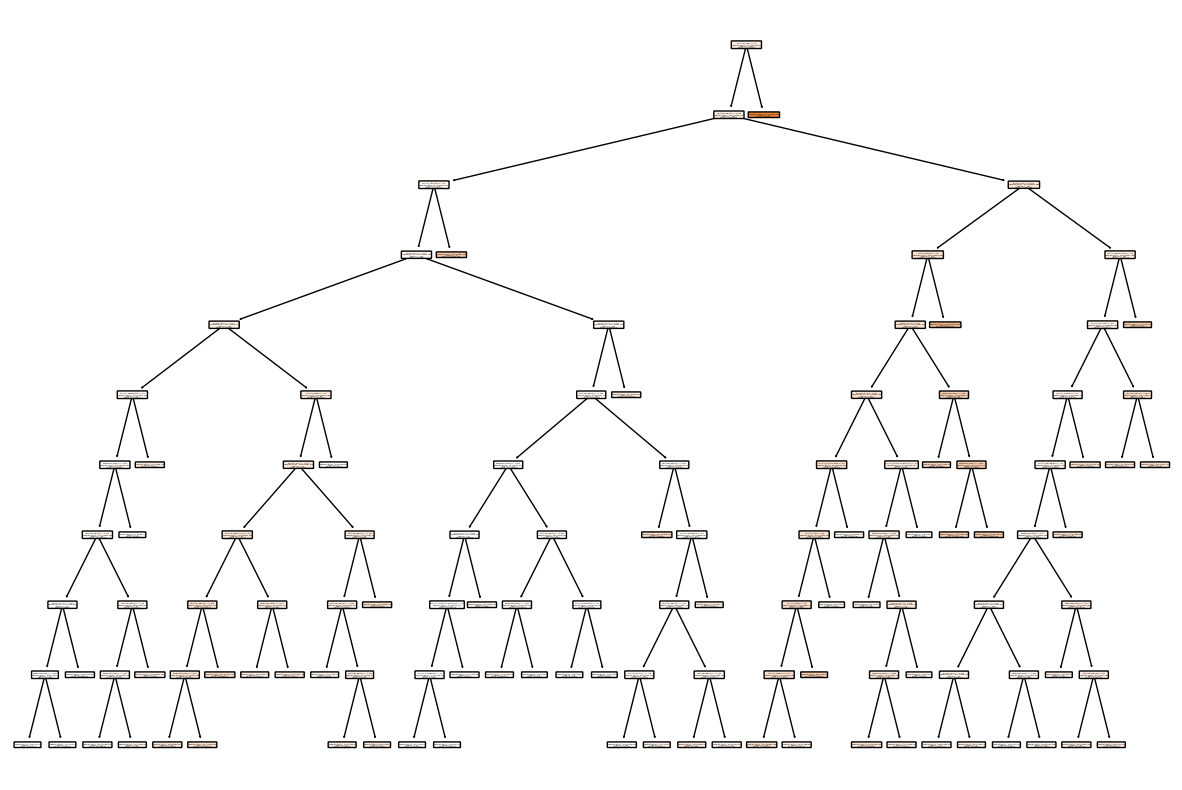

In [40]:
# Specify the feature names
numeric_feature_names = X_train.select_dtypes(include=['float64', 'int64']).columns
categorical_feature_names = best_estimator_dt.named_steps['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out(X_train[categorical_features].columns)
all_feature_names = list(numeric_feature_names) + list(categorical_feature_names)

# Plotting the decision tree
plt.figure(figsize=(15, 10))
plot_tree(best_estimator_dt.named_steps['dt'], feature_names=all_feature_names, filled=True, rounded=True)
plt.show()

In [42]:
# Get feature importance
feature_importance = best_estimator_dt.named_steps['dt'].feature_importances_

# Display feature importance scores
print("Feature Importances:")
for feature, importance in sorted(zip(all_feature_names, feature_importance), key=lambda x: x[1], reverse=True)[:3]:
    print(f"{feature}: {importance}")

Feature Importances:
Country_Israel: 0.3491991906400713
Fertilizer (kg/ha): 0.21912329101788958
Rainfall (mm): 0.18234020274551058
